In [2]:
from pathlib import Path
import os

import torch
import torch.nn as nn
from captum.attr import IntegratedGradients
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from models import TMeanNet, DepressionDetector, TAMFN
from datasets import get_dvlog_dataloader

os.environ["WANDB_NOTEBOOK_NAME"] = "attribution.ipynb" # temporary env variable
plt.style.use("ggplot")

/opt/homebrew/Caskroom/miniforge/base/envs/pytorchenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniforge/base/envs/pytorchenv/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load Data

In [3]:
male_loader = get_dvlog_dataloader(
    "../dvlog-dataset/", "valid", batch_size=128, gender="m"
)
female_loader = get_dvlog_dataloader(
    "../dvlog-dataset/", "valid", batch_size=128, gender="f"
)
Xm, ym = next(iter(male_loader))
Xf, yf = next(iter(female_loader))

Xmd = Xm[ym==1]
Xfd = Xf[yf==1]
Xmn = Xm[ym==0]
Xfn = Xf[yf==0]
print(f"#male depressed: {Xmd.shape[0]}, #female depressed: {Xfd.shape[0]}")
print(f"#male undepressed: {Xmn.shape[0]}, #female undepressed: {Xfn.shape[0]}")
print(f"shape of Xmd: {Xmd.shape}, shape of Xfd: {Xfd.shape}")
print(f"shape of Xmu: {Xmn.shape}, shape of Xfu: {Xfn.shape}")

visual_features_idx = list(range(136))  
audio_features_idx = list(range(136, 161)) 

#male depressed: 21, #female depressed: 36
#male undepressed: 19, #female undepressed: 26
shape of Xmd: torch.Size([21, 1242, 161]), shape of Xfd: torch.Size([36, 1843, 161])
shape of Xmu: torch.Size([19, 1242, 161]), shape of Xfu: torch.Size([26, 1843, 161])


## 1. TMeanNet

In [3]:
model_path = Path("./artifacts/best_model:v25/")
if not model_path.exists():
    # download models from wandb website
    wandb.init()
    model_path = Path(wandb.use_artifact("allenyolk/dvlog/best_model:v25").download())
sd = torch.load(model_path / "best_model.pt", map_location="cpu")

net1 = TMeanNet(hidden_sizes=[512, 512, 512])
net1.load_state_dict(sd)

net1 = nn.Sequential(
    net1, 
    nn.Sigmoid()
)
net1.eval()

# attribution using Integrated Gradient Method
ig = IntegratedGradients(net1)

### a. Male Depressed

In [4]:
def ig_attribute(ig, input, n_steps=50):
    attributions, delta = ig.attribute(
        input, target=0, return_convergence_delta=True, n_steps=n_steps
    )
    print(f"mean(delta)={delta.mean()}, lower abs is better!")

    attributions_avg_t = attributions.mean(dim=1)
    print(attributions_avg_t.shape)
    print(attributions_avg_t.abs().max())

    return pd.DataFrame(attributions_avg_t.numpy(), columns=[f'Feature_{i}' for i in range(161)])

data = ig_attribute(ig, Xmd)

mean(delta)=3.452893470886154e-05, lower abs is better!
torch.Size([21, 161])
tensor(0.0002, dtype=torch.float64)


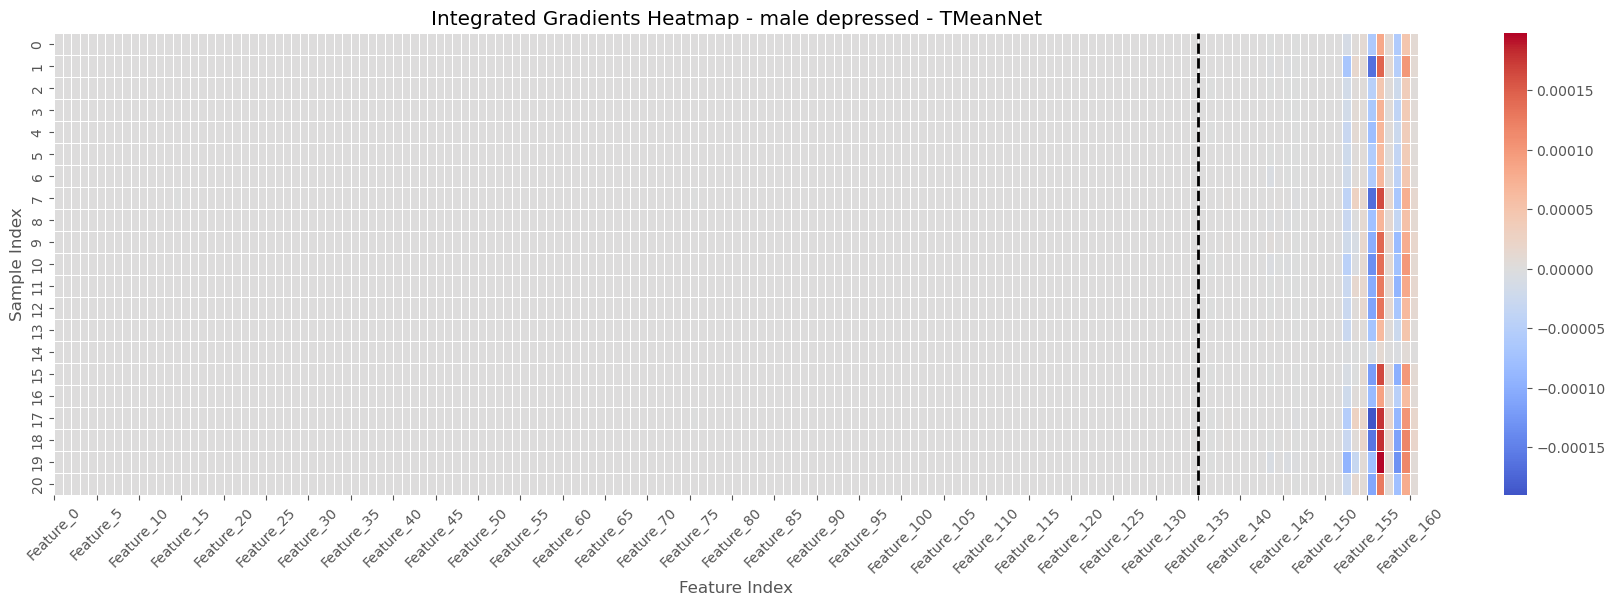

/var/folders/pf/8d2xqvf51pn0q9w51blgjmqc0000gn/T/ipykernel_45509/3874884795.py:15: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=data, inner="quartile", bw=0.2)


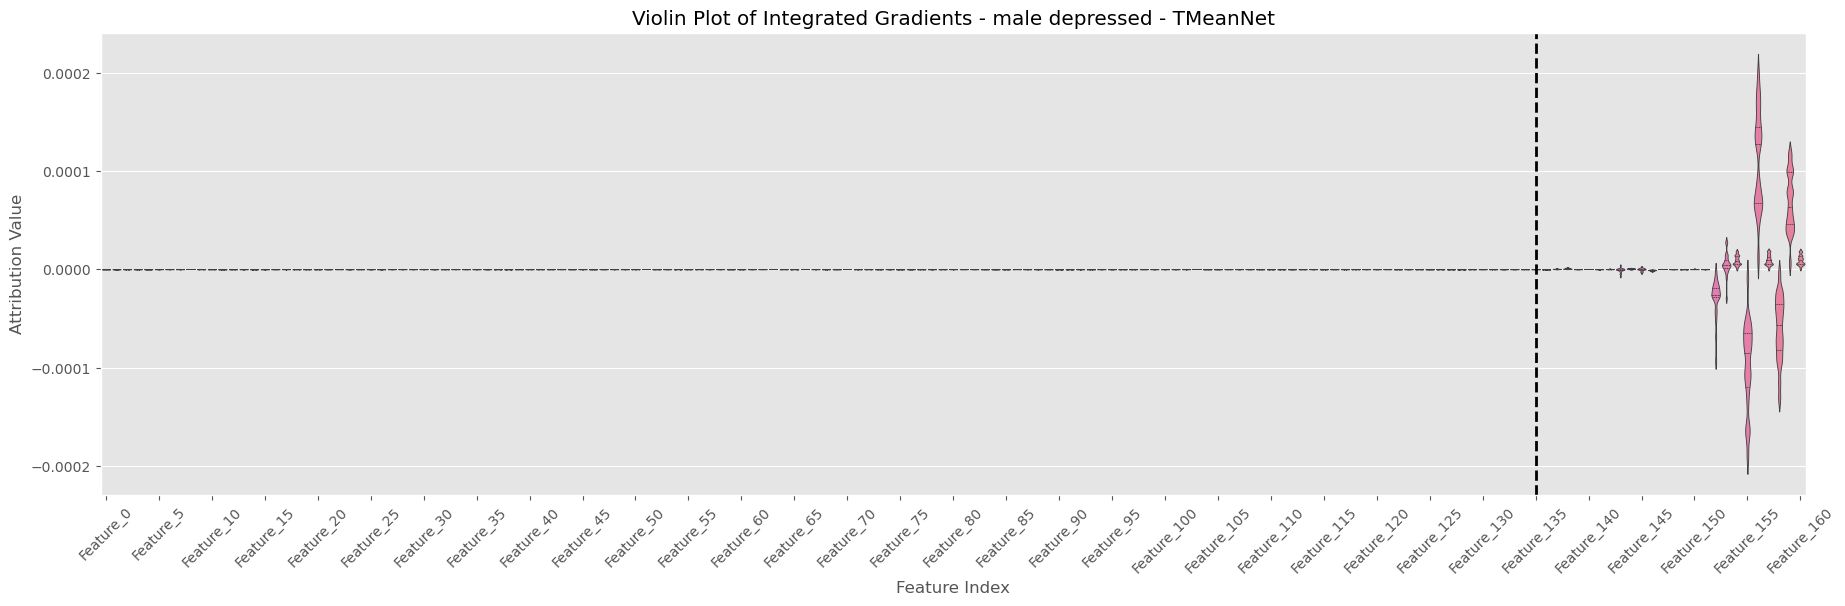

In [5]:
# 使用热力图显示平均归因值
def plot_heatmap(data, condition):
    plt.figure(figsize=(22, 6))
    sns.heatmap(data, cmap='coolwarm', linewidths=0.5, center=0.)
    plt.xlabel('Feature Index')
    plt.ylabel('Sample Index')
    plt.title(f'Integrated Gradients Heatmap - {condition}')
    plt.axvline(x=max(visual_features_idx), color='black', linestyle='--', linewidth=2)
    plt.xticks(range(0, 161, 5), data.columns[0:161:5], rotation=45)
    plt.show()

def plot_violin(data, condition):
    # 绘制小提琴图
    plt.figure(figsize=(22, 6))
    sns.violinplot(data=data, inner="quartile", bw=0.2)

    # 在小提琴图上添加标记以区分视觉特征和音频特征
    plt.axvline(x=max(visual_features_idx), color='black', linestyle='--', linewidth=2)

    plt.xlabel('Feature Index')
    plt.ylabel('Attribution Value')
    plt.xticks(range(0, 161, 5), rotation=45)
    plt.title(f'Violin Plot of Integrated Gradients - {condition}')
    plt.show()

plot_heatmap(data, "male depressed - TMeanNet")
plot_violin(data, "male depressed - TMeanNet")

### b. Female Depressed

mean(delta)=3.4821538273201874e-05, lower abs is better!
torch.Size([36, 161])
tensor(0.0002, dtype=torch.float64)


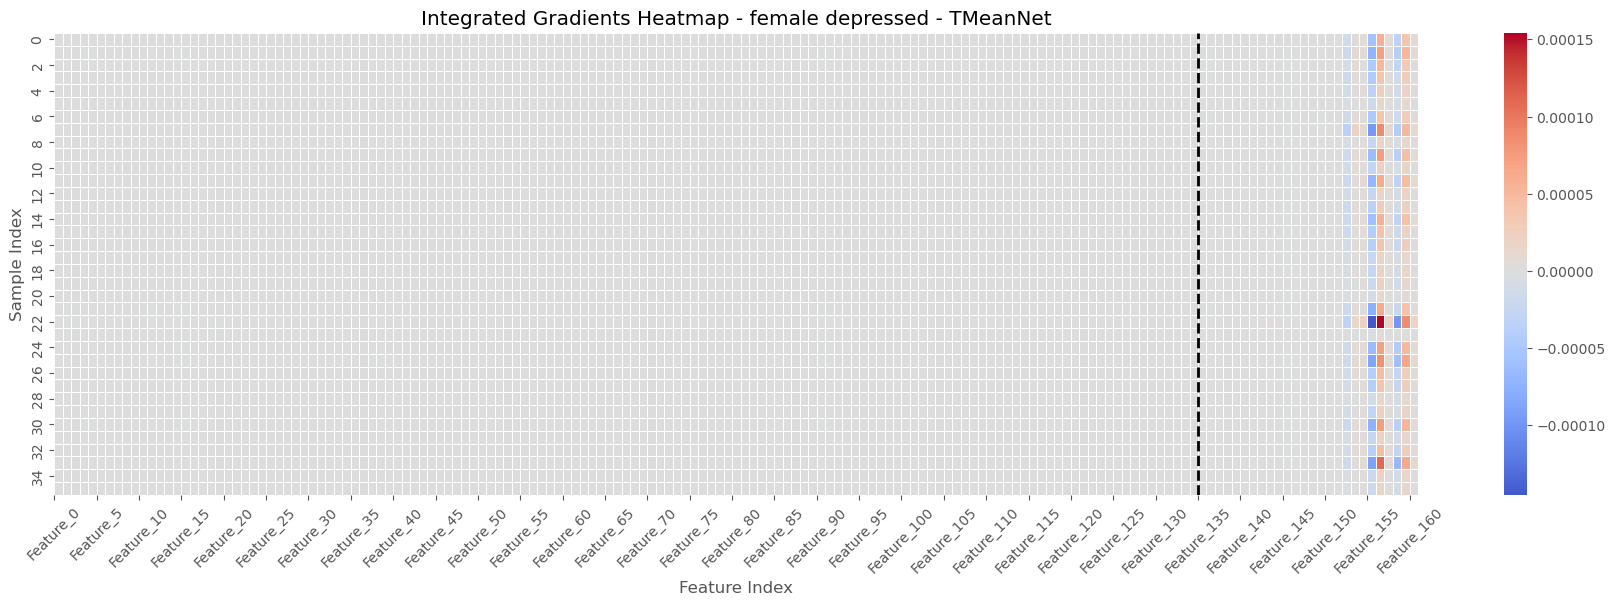

/var/folders/pf/8d2xqvf51pn0q9w51blgjmqc0000gn/T/ipykernel_45509/3874884795.py:15: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=data, inner="quartile", bw=0.2)


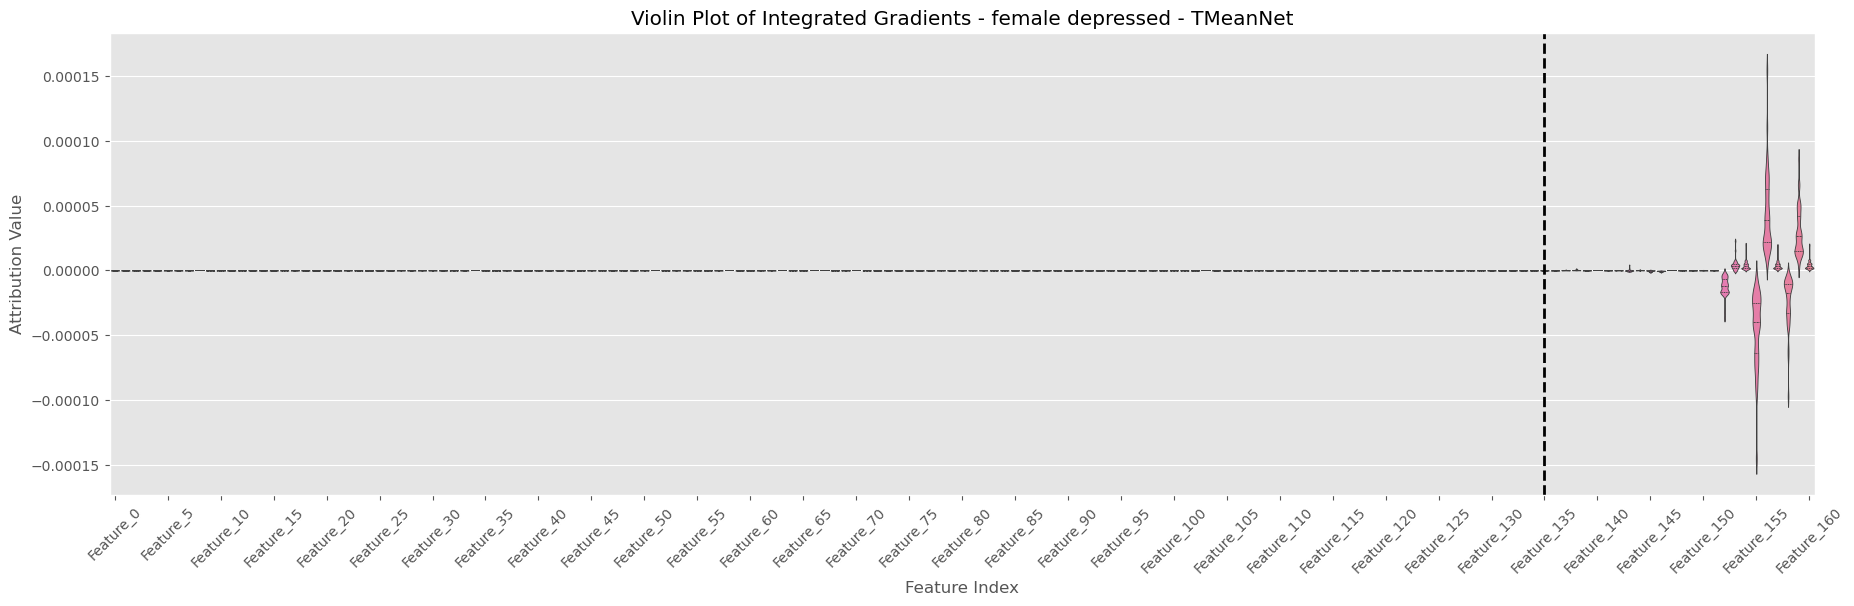

In [6]:
data = ig_attribute(ig, Xfd)
plot_heatmap(data, "female depressed - TMeanNet")
plot_violin(data, "female depressed - TMeanNet")

### c. Male Normal

mean(delta)=-1.5601482859915326e-05, lower abs is better!
torch.Size([19, 161])
tensor(0.0002, dtype=torch.float64)


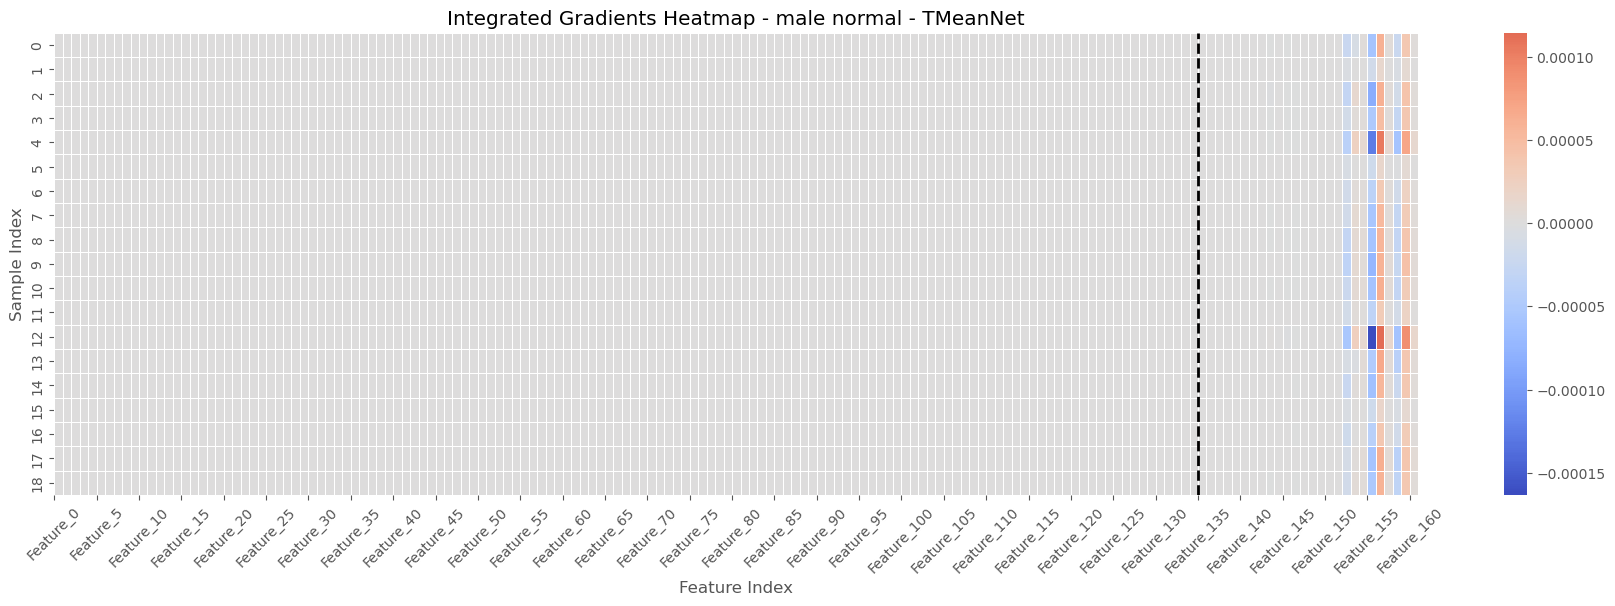

/var/folders/pf/8d2xqvf51pn0q9w51blgjmqc0000gn/T/ipykernel_45509/3874884795.py:15: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=data, inner="quartile", bw=0.2)


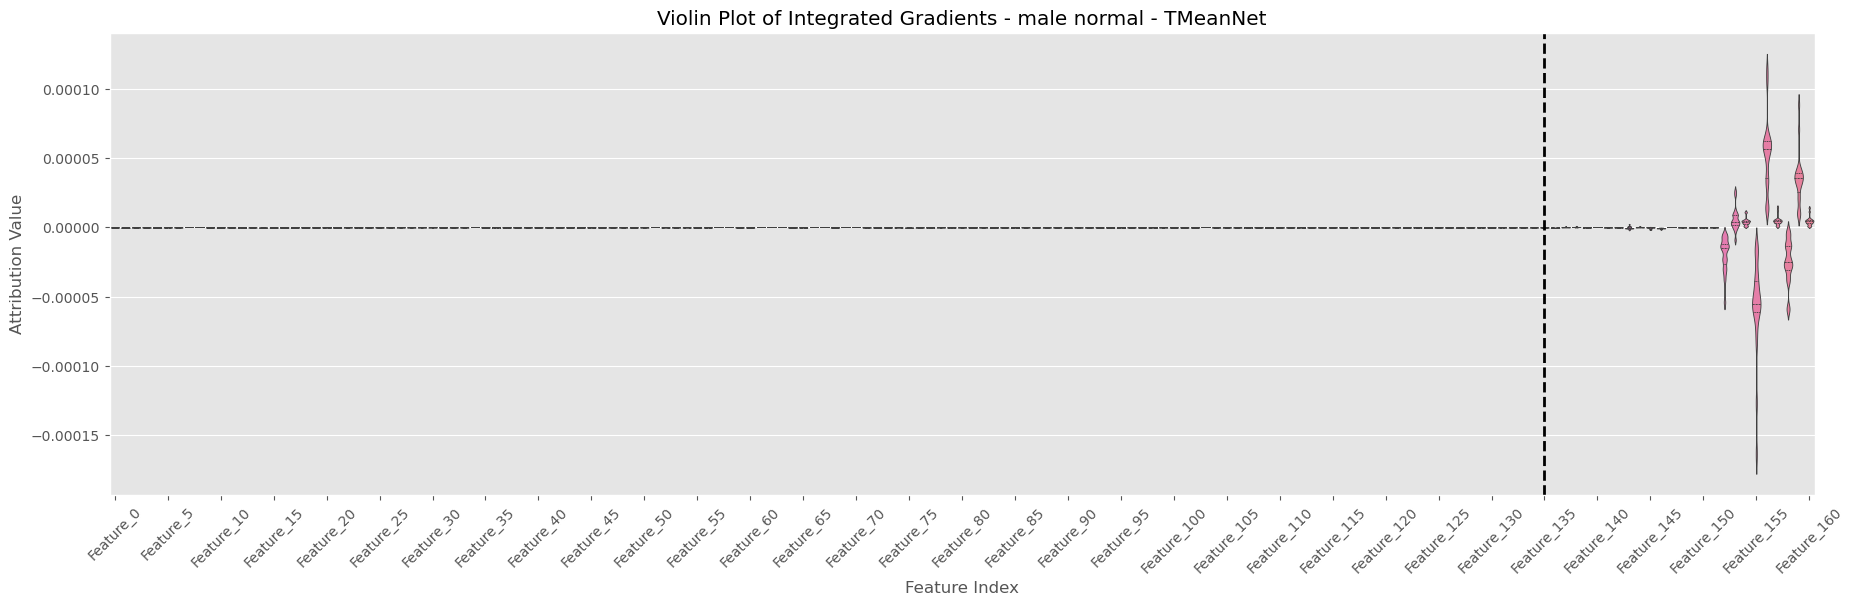

In [7]:
data = ig_attribute(ig, Xmn)
plot_heatmap(data, "male normal - TMeanNet")
plot_violin(data, "male normal - TMeanNet")

### d. Female Normal

mean(delta)=-1.0760099787253314e-05, lower abs is better!
torch.Size([26, 161])
tensor(0.0001, dtype=torch.float64)


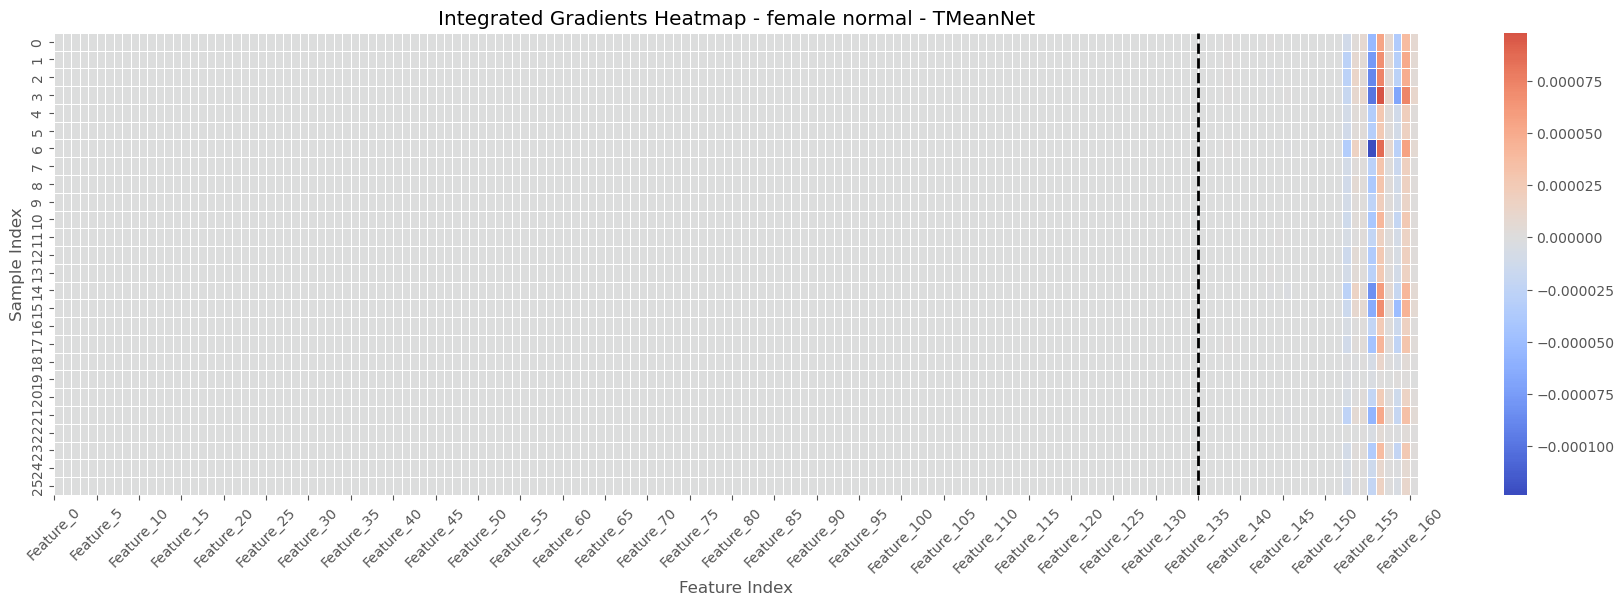

/var/folders/pf/8d2xqvf51pn0q9w51blgjmqc0000gn/T/ipykernel_45509/3874884795.py:15: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=data, inner="quartile", bw=0.2)


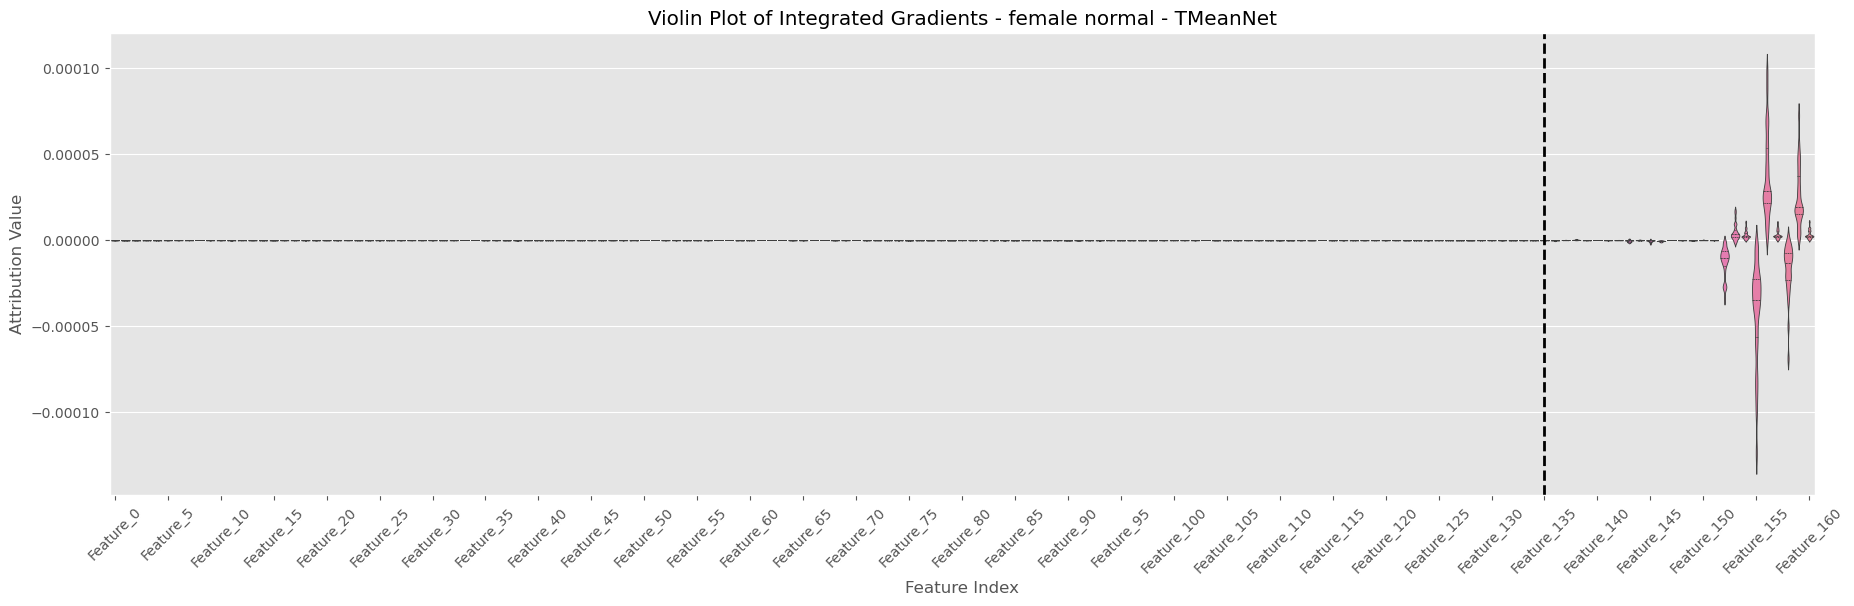

In [8]:
data = ig_attribute(ig, Xfn)
plot_heatmap(data, "female normal - TMeanNet")
plot_violin(data, "female normal - TMeanNet")

## 2. DepressionDetector

In [4]:
model_path = Path("./artifacts/best_model:v32/")
if not model_path.exists():
    # download models from wandb website
    wandb.init()
    model_path = Path(wandb.use_artifact("allenyolk/dvlog/best_model:v32").download())
sd = torch.load(model_path / "best_model.pt", map_location="cpu")

def process_state_dict(sd):
    new_sd = {}
    for k, v in sd.items():
        if k.startswith("module."):
            new_sd[k[7:]] = v
        else:
            new_sd[k] = v
    return new_sd

sd = process_state_dict(sd)

net2 = DepressionDetector(d=256, l=6, t_downsample=4)
net2.load_state_dict(sd)

net2 = nn.Sequential(
    net2, 
    nn.Sigmoid()
)
net2.eval()

# attribution using Integrated Gradient Method
ig = IntegratedGradients(net2)

In [5]:
def ig_attribute(ig, input, n_steps=50):
    attributions, delta = ig.attribute(
        input, target=0, return_convergence_delta=True, n_steps=n_steps
    )
    print(f"mean(delta)={delta.mean()}, lower abs is better!")

    attributions_avg_t = attributions.mean(dim=1)
    print(attributions_avg_t.shape)
    print(attributions_avg_t.abs().max())

    return pd.DataFrame(attributions_avg_t.numpy(), columns=[f'Feature_{i}' for i in range(161)])

# 使用热力图显示平均归因值
def plot_heatmap(data, condition):
    plt.figure(figsize=(22, 6))
    sns.heatmap(data, cmap='coolwarm', linewidths=0.5, center=0.)
    plt.xlabel('Feature Index')
    plt.ylabel('Sample Index')
    plt.title(f'Integrated Gradients Heatmap - {condition}')
    plt.axvline(x=max(visual_features_idx), color='black', linestyle='--', linewidth=2)
    plt.xticks(range(0, 161, 5), data.columns[0:161:5], rotation=45)
    plt.show()

def plot_violin(data, condition):
    # 绘制小提琴图
    plt.figure(figsize=(22, 6))
    sns.violinplot(data=data, inner="quartile", bw=0.2)

    # 在小提琴图上添加标记以区分视觉特征和音频特征
    plt.axvline(x=max(visual_features_idx), color='black', linestyle='--', linewidth=2)

    plt.xlabel('Feature Index')
    plt.ylabel('Attribution Value')
    plt.xticks(range(0, 161, 5), rotation=45)
    plt.title(f'Violin Plot of Integrated Gradients - {condition}')
    plt.show()

### a. Male Depressed

mean(delta)=0.1965080569481544, lower abs is better!
torch.Size([21, 161])
tensor(0.0025, dtype=torch.float64)


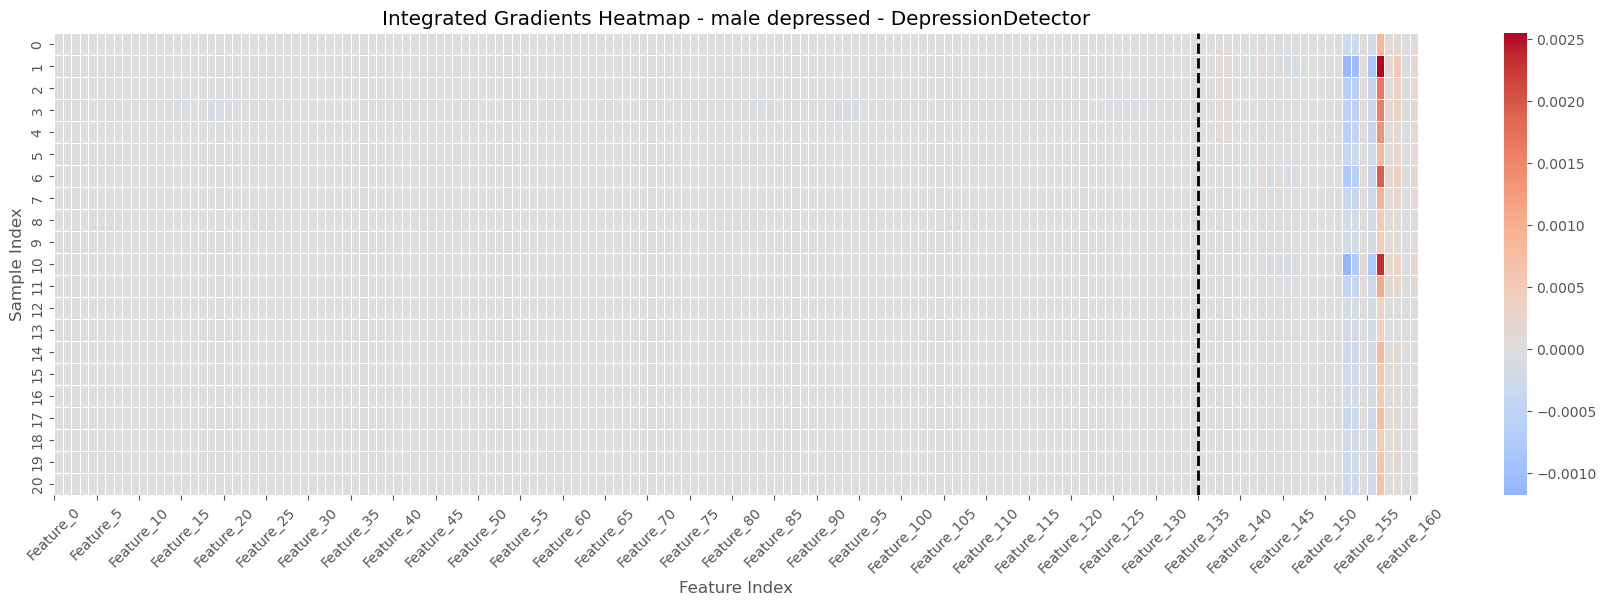

/var/folders/pf/8d2xqvf51pn0q9w51blgjmqc0000gn/T/ipykernel_45509/3149416675.py:27: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=data, inner="quartile", bw=0.2)


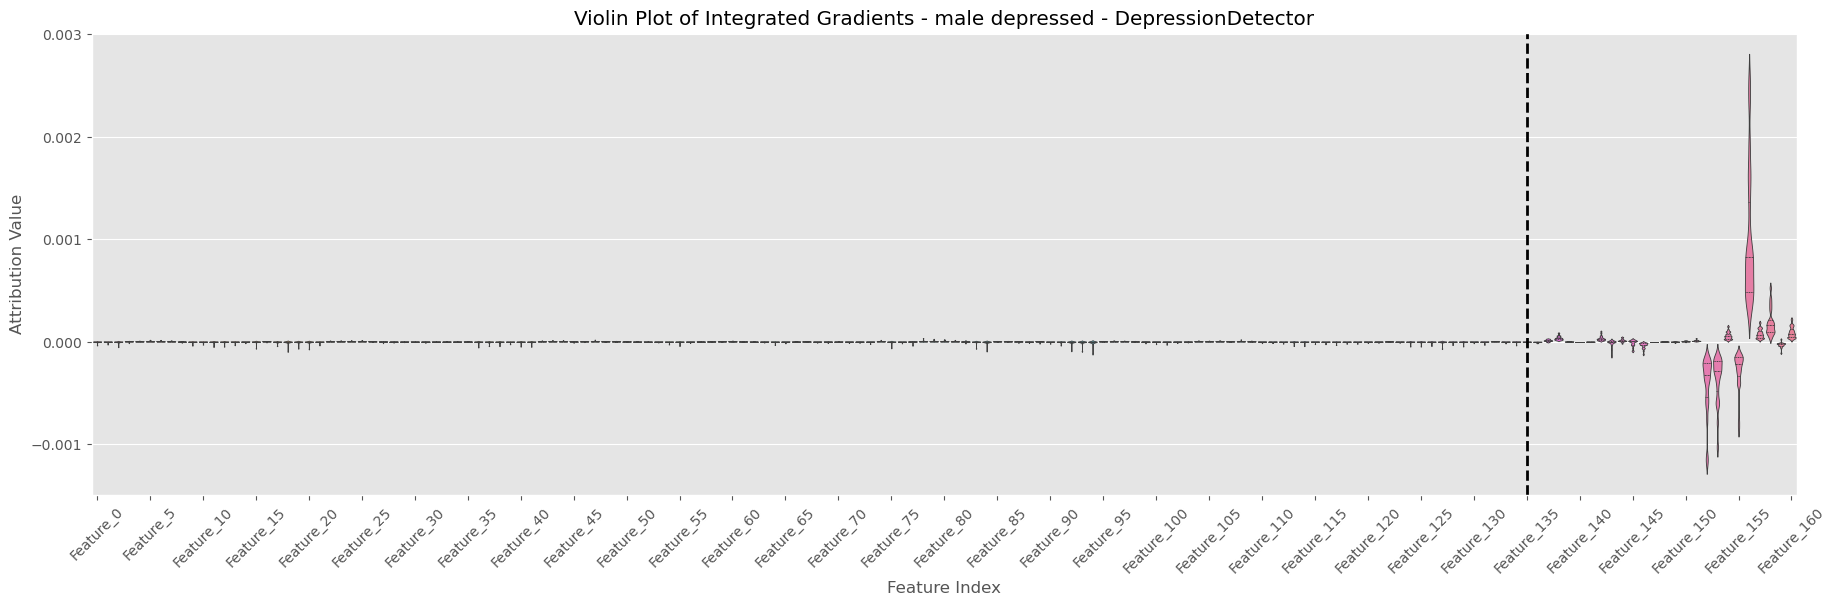

In [11]:
data = ig_attribute(ig, Xmd, n_steps=20)
plot_heatmap(data, "male depressed - DepressionDetector")
plot_violin(data, "male depressed - DepressionDetector")

### b. Female Depressed

mean(delta)=0.29900132710702215, lower abs is better!
torch.Size([36, 161])
tensor(0.0023, dtype=torch.float64)


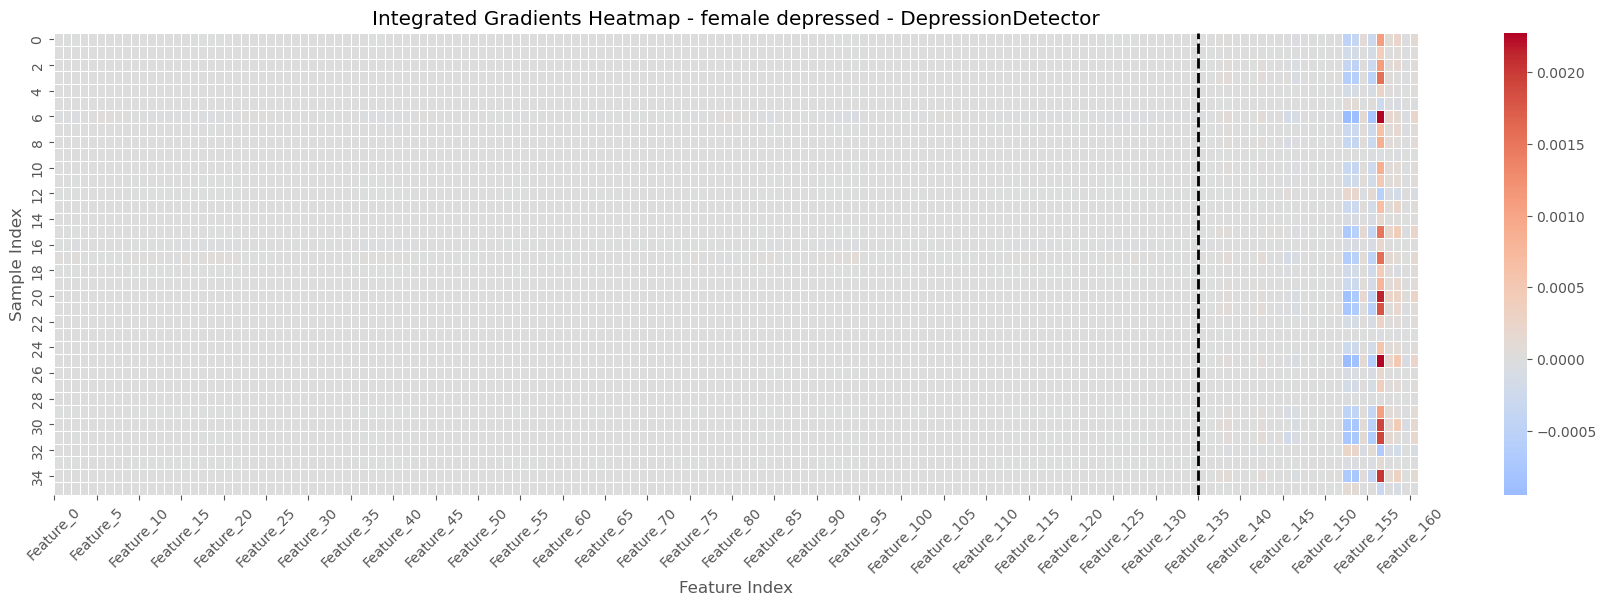

/var/folders/pf/8d2xqvf51pn0q9w51blgjmqc0000gn/T/ipykernel_47055/3149416675.py:27: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=data, inner="quartile", bw=0.2)


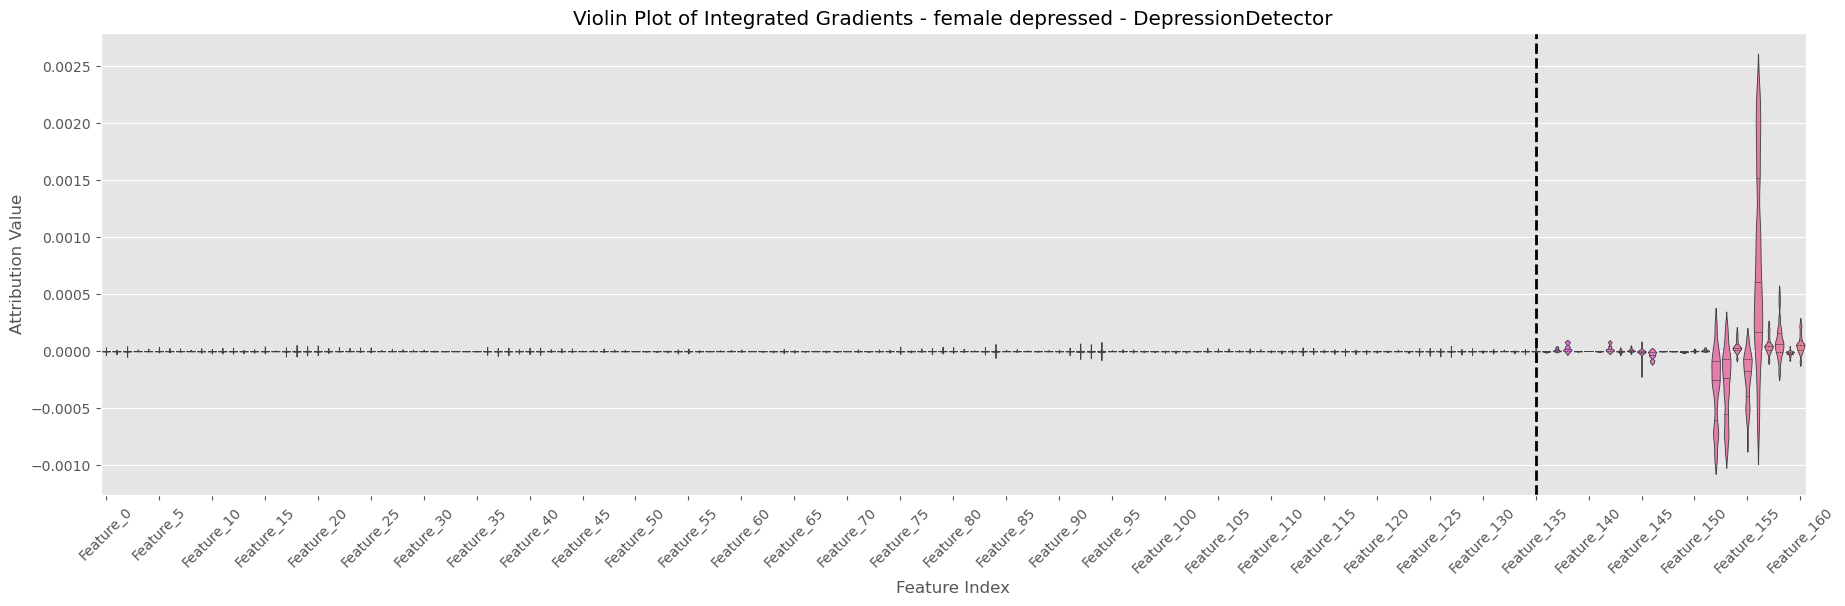

In [6]:
data = ig_attribute(ig, Xfd, n_steps=10)
plot_heatmap(data, "female depressed - DepressionDetector")
plot_violin(data, "female depressed - DepressionDetector")

### c. Male Normal

mean(delta)=-0.5566693503368675, lower abs is better!
torch.Size([19, 161])
tensor(0.0029, dtype=torch.float64)


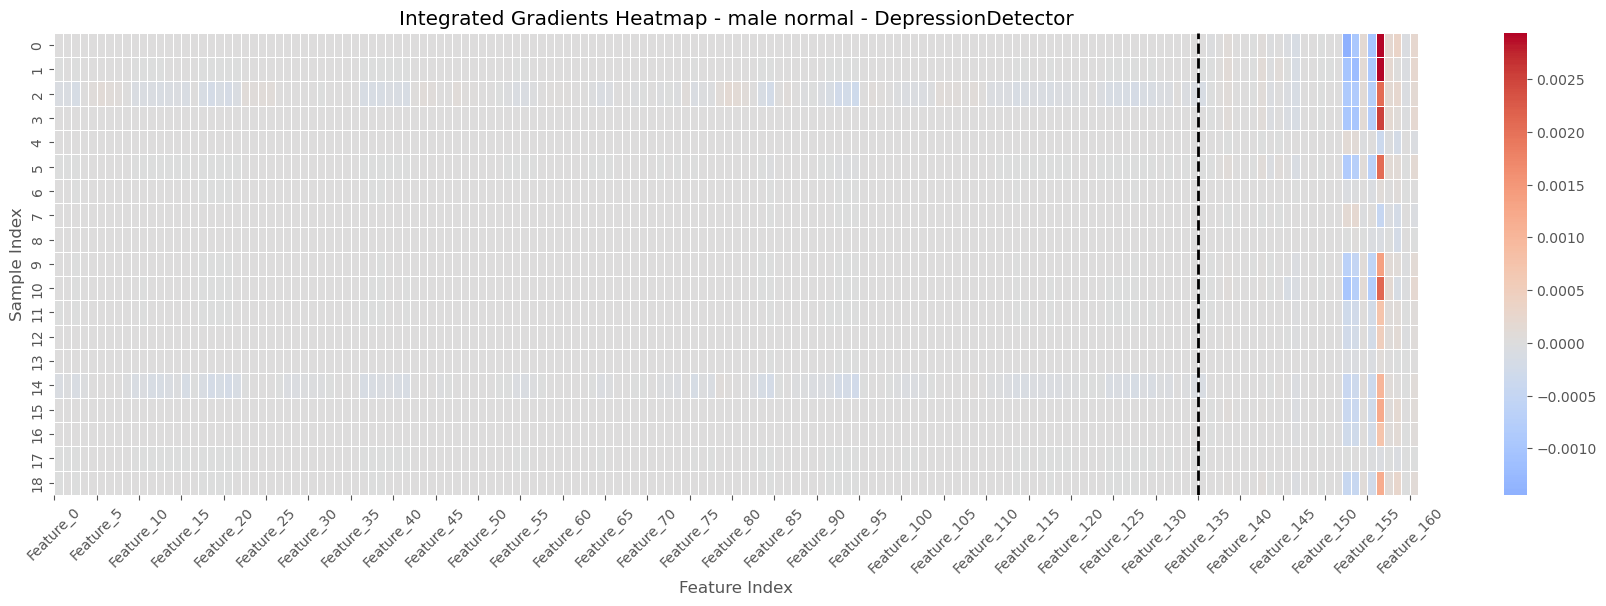

/var/folders/pf/8d2xqvf51pn0q9w51blgjmqc0000gn/T/ipykernel_47055/3149416675.py:27: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=data, inner="quartile", bw=0.2)


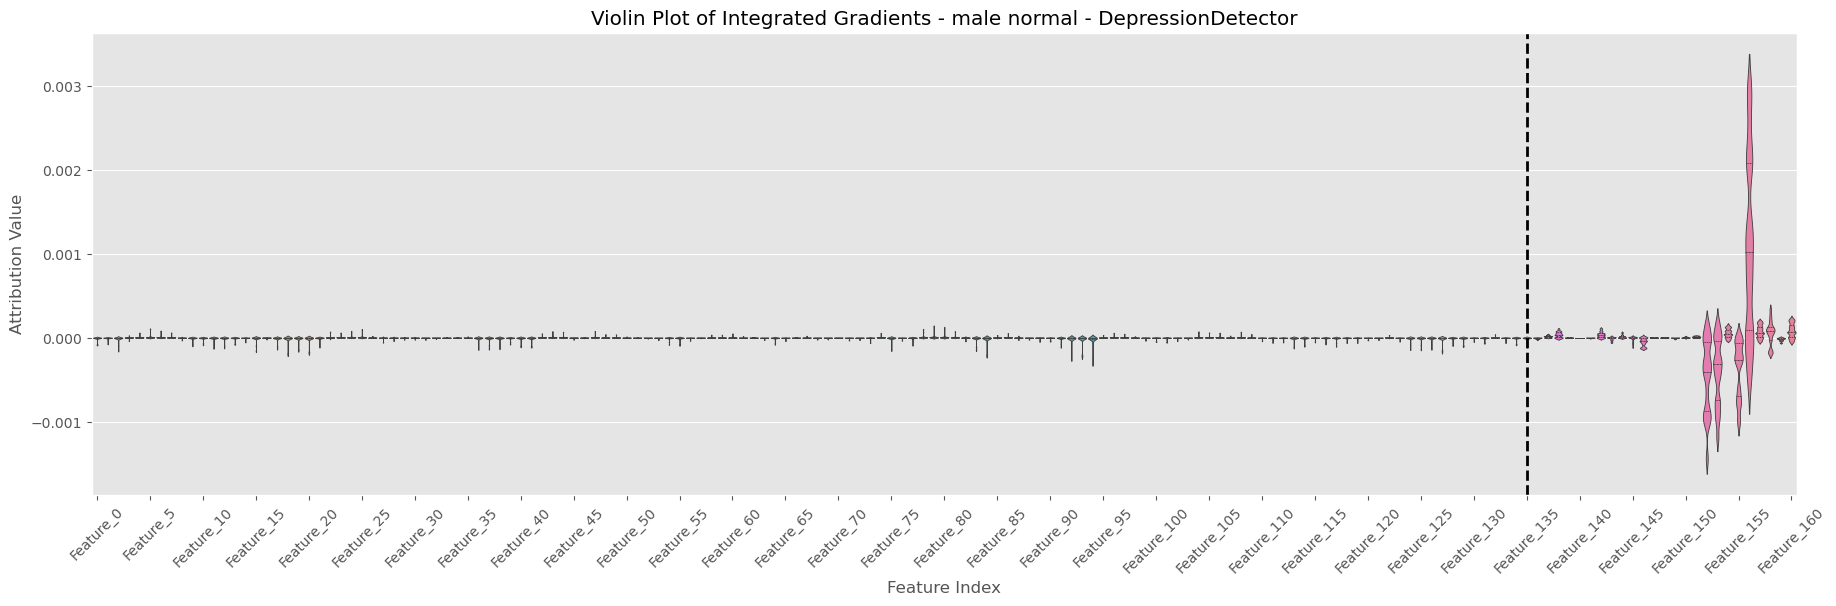

In [7]:
data = ig_attribute(ig, Xmn, n_steps=20)
plot_heatmap(data, "male normal - DepressionDetector")
plot_violin(data, "male normal - DepressionDetector")

### d. Femal Normal

mean(delta)=0.1157638383040631, lower abs is better!
torch.Size([26, 161])
tensor(0.0028, dtype=torch.float64)


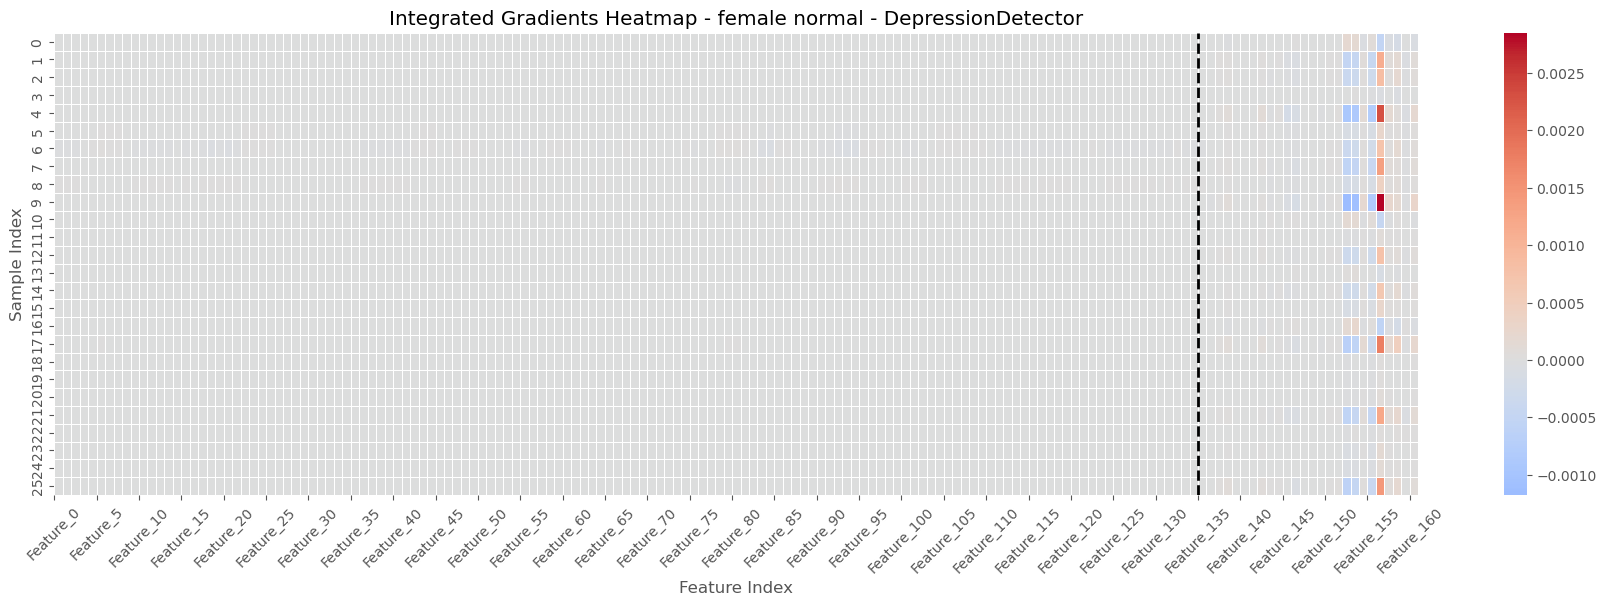

/var/folders/pf/8d2xqvf51pn0q9w51blgjmqc0000gn/T/ipykernel_47055/3149416675.py:27: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=data, inner="quartile", bw=0.2)


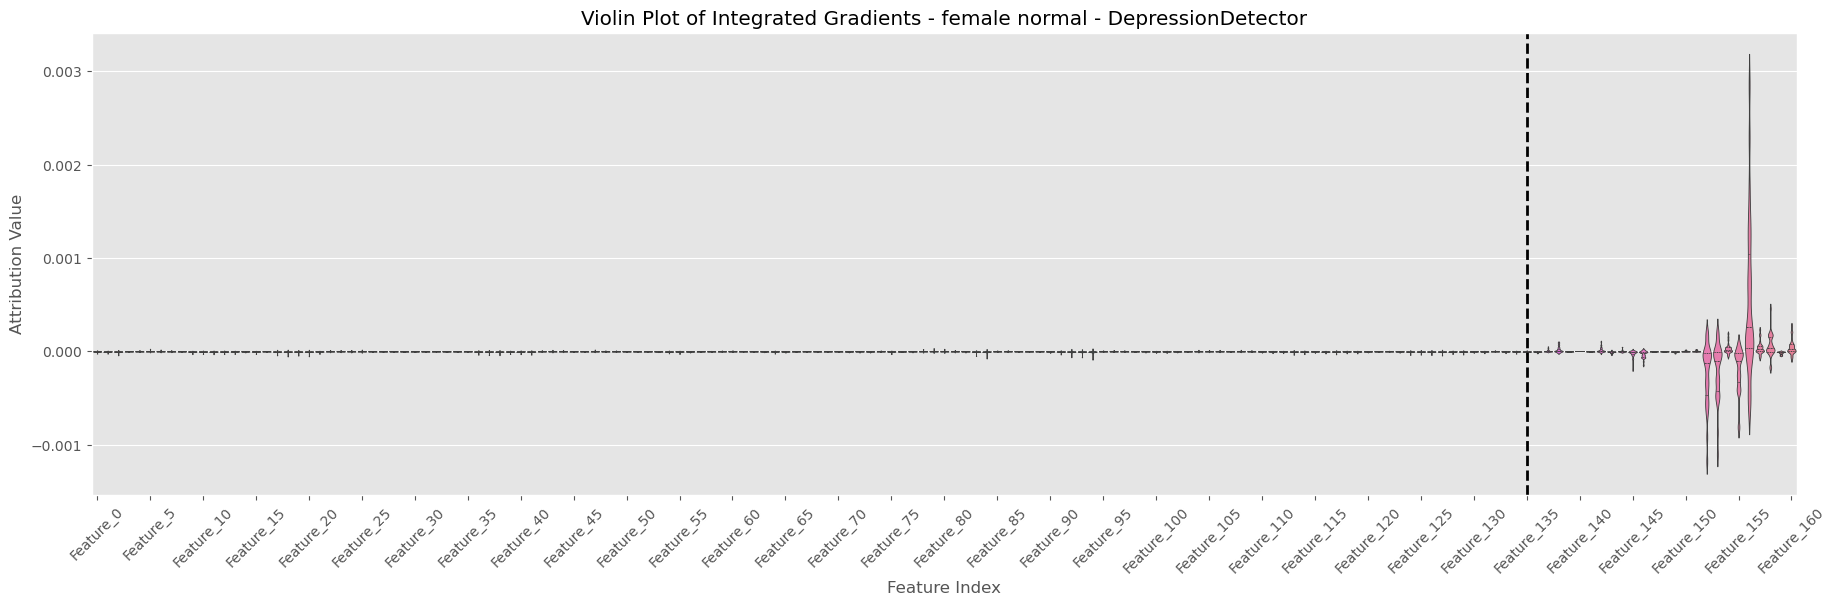

In [8]:
data = ig_attribute(ig, Xfn, n_steps=10)
plot_heatmap(data, "female normal - DepressionDetector")
plot_violin(data, "female normal - DepressionDetector")

## 3. TAMFN

In [9]:
model_path = Path("./artifacts/best_model:v37/")
if not model_path.exists():
    # download models from wandb website
    wandb.init()
    model_path = Path(wandb.use_artifact("allenyolk/dvlog/best_model:v37").download())
sd = torch.load(model_path / "best_model.pt", map_location="cpu")
sd = process_state_dict(sd)

net3 = TAMFN(d=256, l=6, t_downsample=4)
net3.load_state_dict(sd)

net3 = nn.Sequential(
    net3, 
    nn.Sigmoid()
)
net3.eval()

# attribution using Integrated Gradient Method
ig = IntegratedGradients(net3)

In [10]:
def ig_attribute(ig, input, n_steps=50):
    attributions, delta = ig.attribute(
        input, target=0, return_convergence_delta=True, n_steps=n_steps
    )
    print(f"mean(delta)={delta.mean()}, lower abs is better!")

    attributions_avg_t = attributions.mean(dim=1)
    print(attributions_avg_t.shape)
    print(attributions_avg_t.abs().max())

    return pd.DataFrame(attributions_avg_t.numpy(), columns=[f'Feature_{i}' for i in range(161)])

# 使用热力图显示平均归因值
def plot_heatmap(data, condition):
    plt.figure(figsize=(22, 6))
    sns.heatmap(data, cmap='coolwarm', linewidths=0.5, center=0.)
    plt.xlabel('Feature Index')
    plt.ylabel('Sample Index')
    plt.title(f'Integrated Gradients Heatmap - {condition}')
    plt.axvline(x=max(visual_features_idx), color='black', linestyle='--', linewidth=2)
    plt.xticks(range(0, 161, 5), data.columns[0:161:5], rotation=45)
    plt.show()

def plot_violin(data, condition):
    # 绘制小提琴图
    plt.figure(figsize=(22, 6))
    sns.violinplot(data=data, inner="quartile", bw=0.2)

    # 在小提琴图上添加标记以区分视觉特征和音频特征
    plt.axvline(x=max(visual_features_idx), color='black', linestyle='--', linewidth=2)

    plt.xlabel('Feature Index')
    plt.ylabel('Attribution Value')
    plt.xticks(range(0, 161, 5), rotation=45)
    plt.title(f'Violin Plot of Integrated Gradients - {condition}')
    plt.show()

### a. Male Depressed

mean(delta)=-0.02072909723706609, lower abs is better!
torch.Size([21, 161])
tensor(0.0021, dtype=torch.float64)


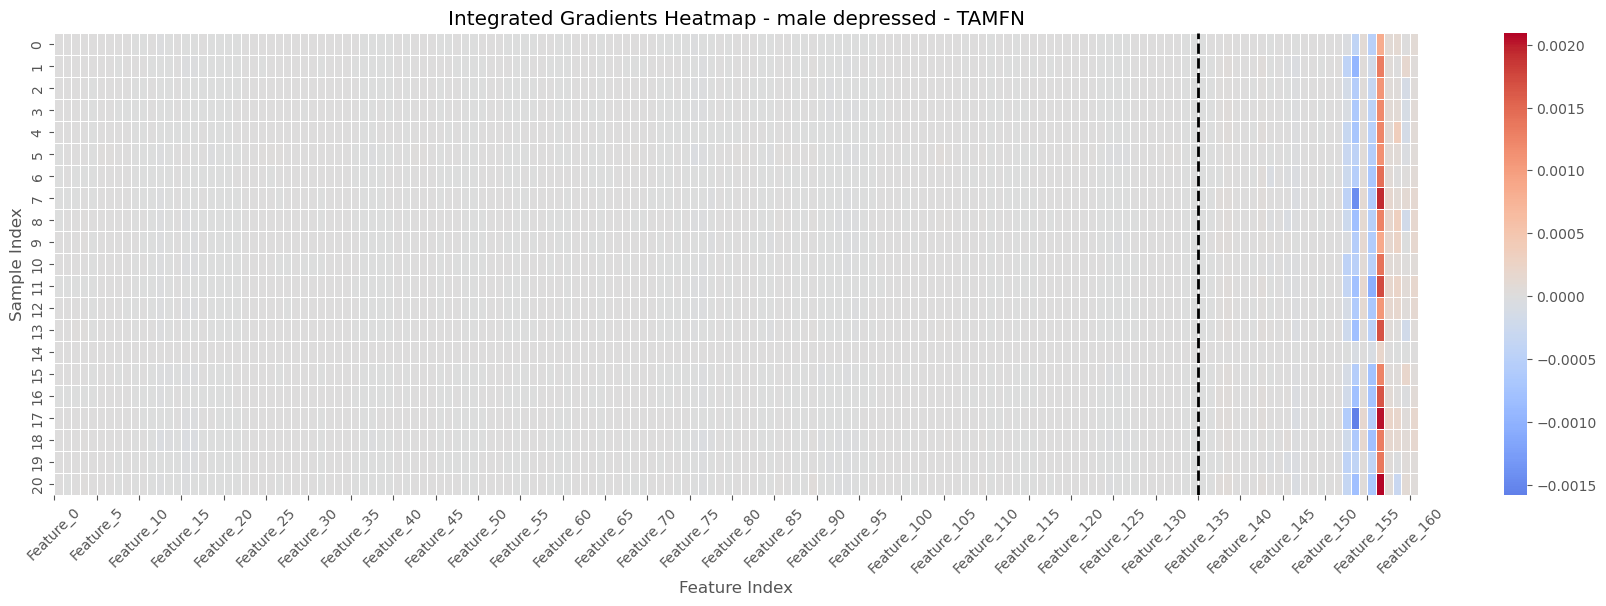

/var/folders/pf/8d2xqvf51pn0q9w51blgjmqc0000gn/T/ipykernel_47055/3149416675.py:27: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=data, inner="quartile", bw=0.2)


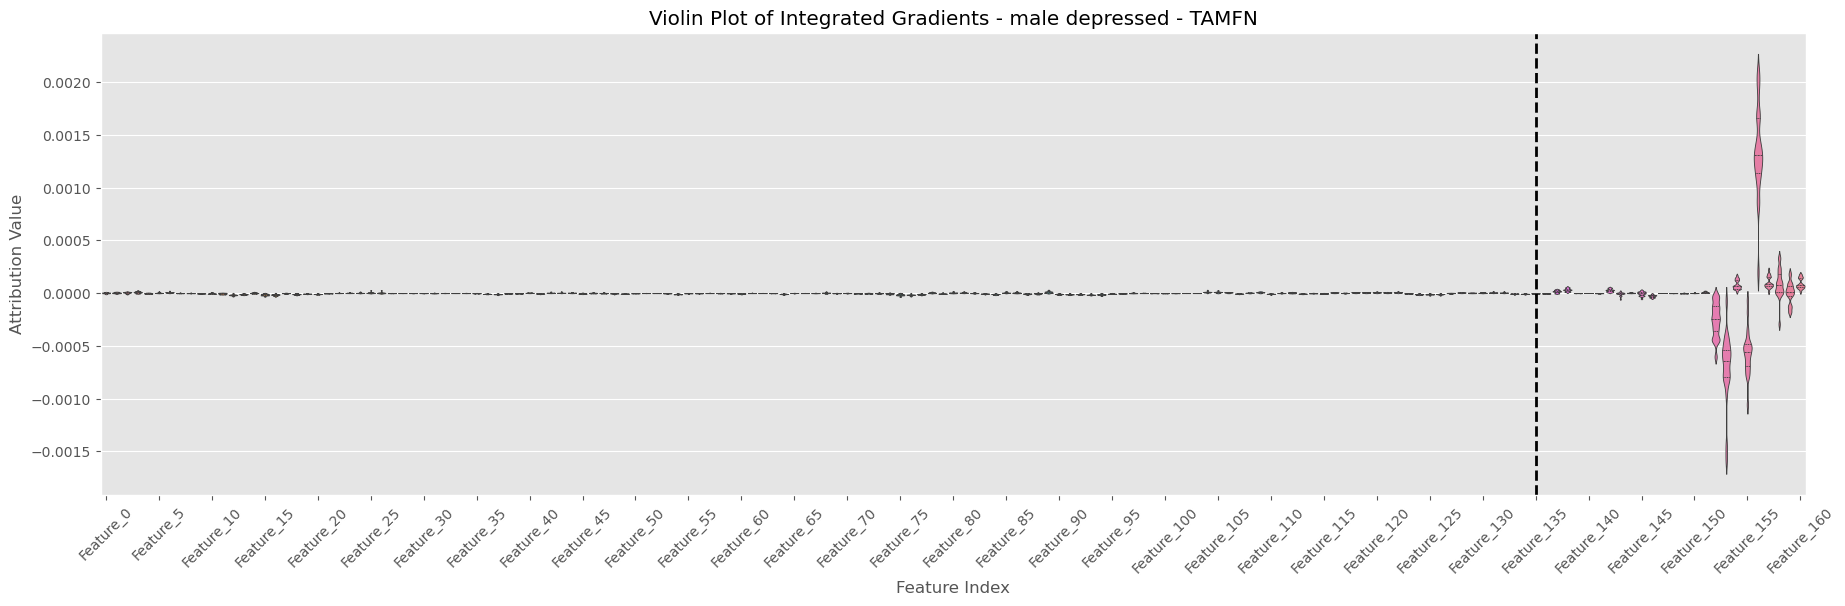

In [11]:
data = ig_attribute(ig, Xmd, n_steps=20)
plot_heatmap(data, "male depressed - TAMFN")
plot_violin(data, "male depressed - TAMFN")

### b. Femal Depressed

mean(delta)=0.015650674742045702, lower abs is better!
torch.Size([36, 161])
tensor(0.0015, dtype=torch.float64)


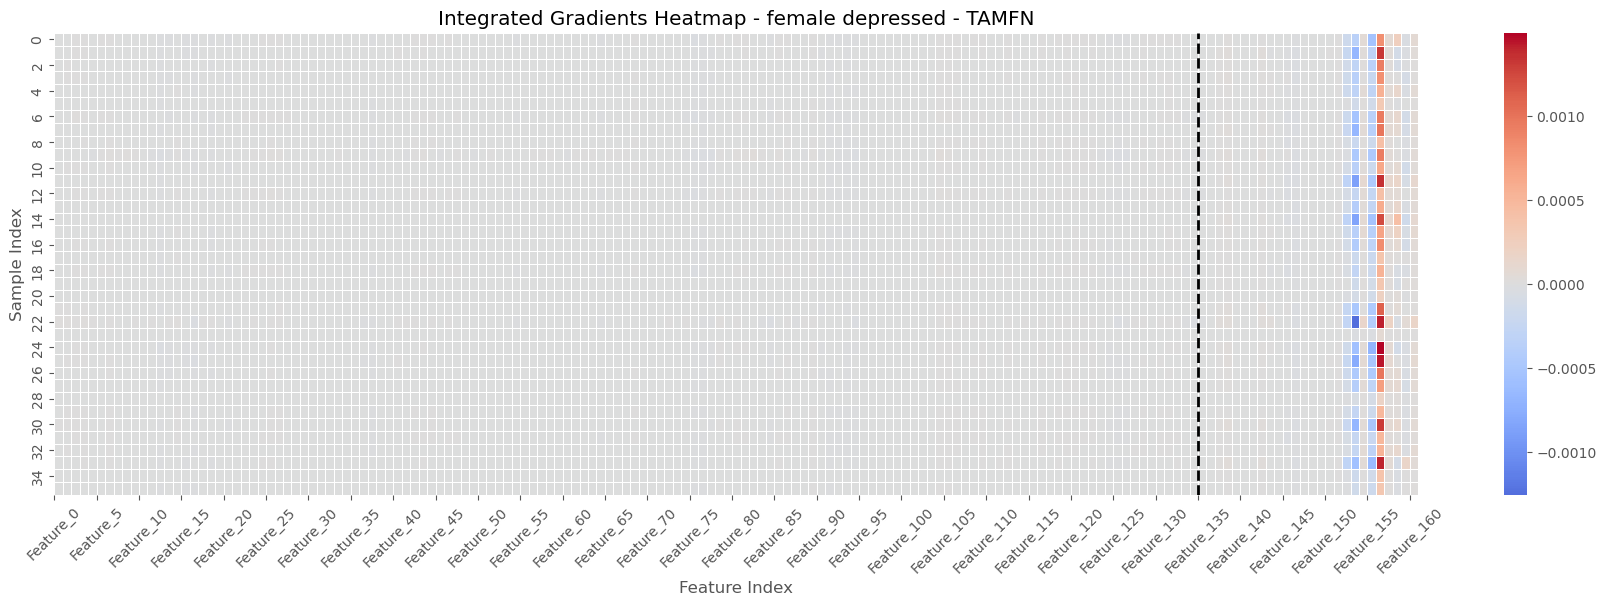

/var/folders/pf/8d2xqvf51pn0q9w51blgjmqc0000gn/T/ipykernel_47055/3149416675.py:27: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=data, inner="quartile", bw=0.2)


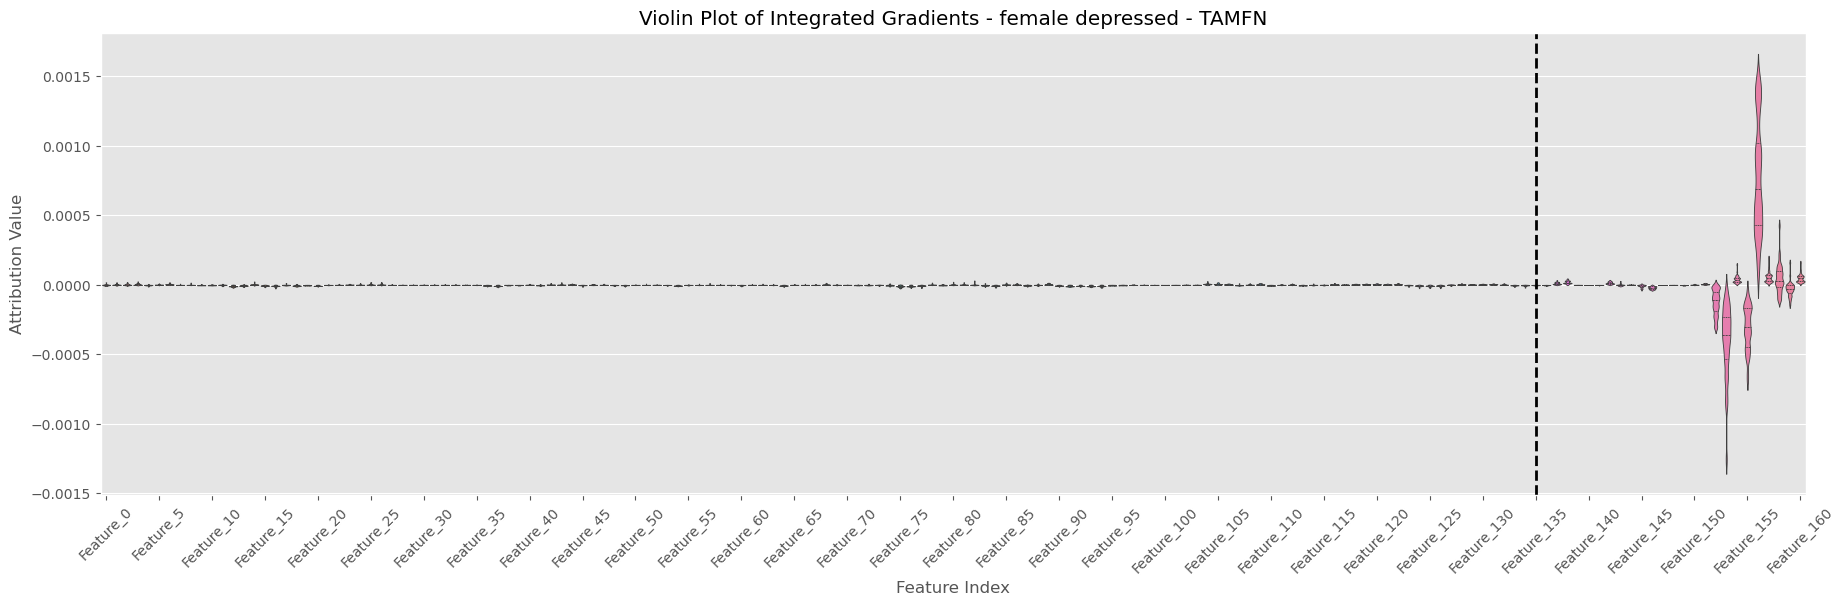

In [12]:
data = ig_attribute(ig, Xfd, n_steps=20)
plot_heatmap(data, "female depressed - TAMFN")
plot_violin(data, "female depressed - TAMFN")

### c. Male Normal

mean(delta)=-0.00804552758485097, lower abs is better!
torch.Size([19, 161])
tensor(0.0017, dtype=torch.float64)


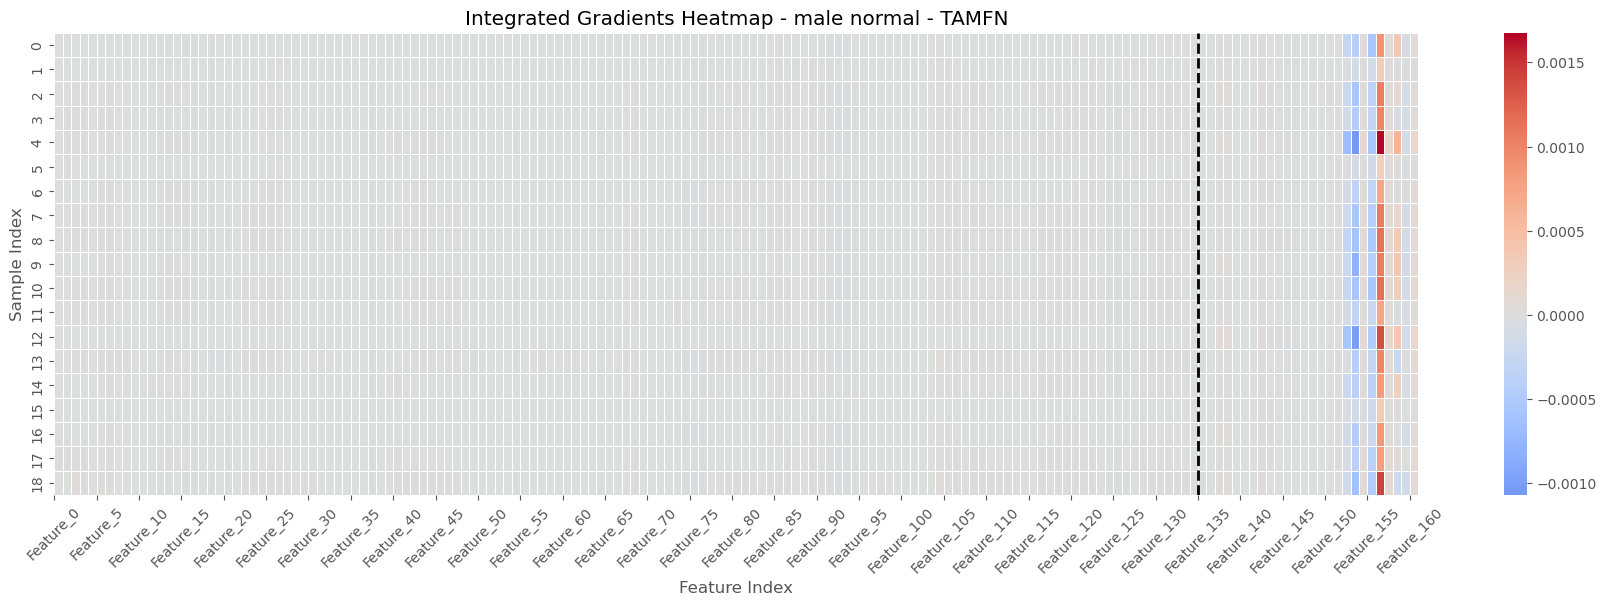

/var/folders/pf/8d2xqvf51pn0q9w51blgjmqc0000gn/T/ipykernel_47055/3149416675.py:27: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=data, inner="quartile", bw=0.2)


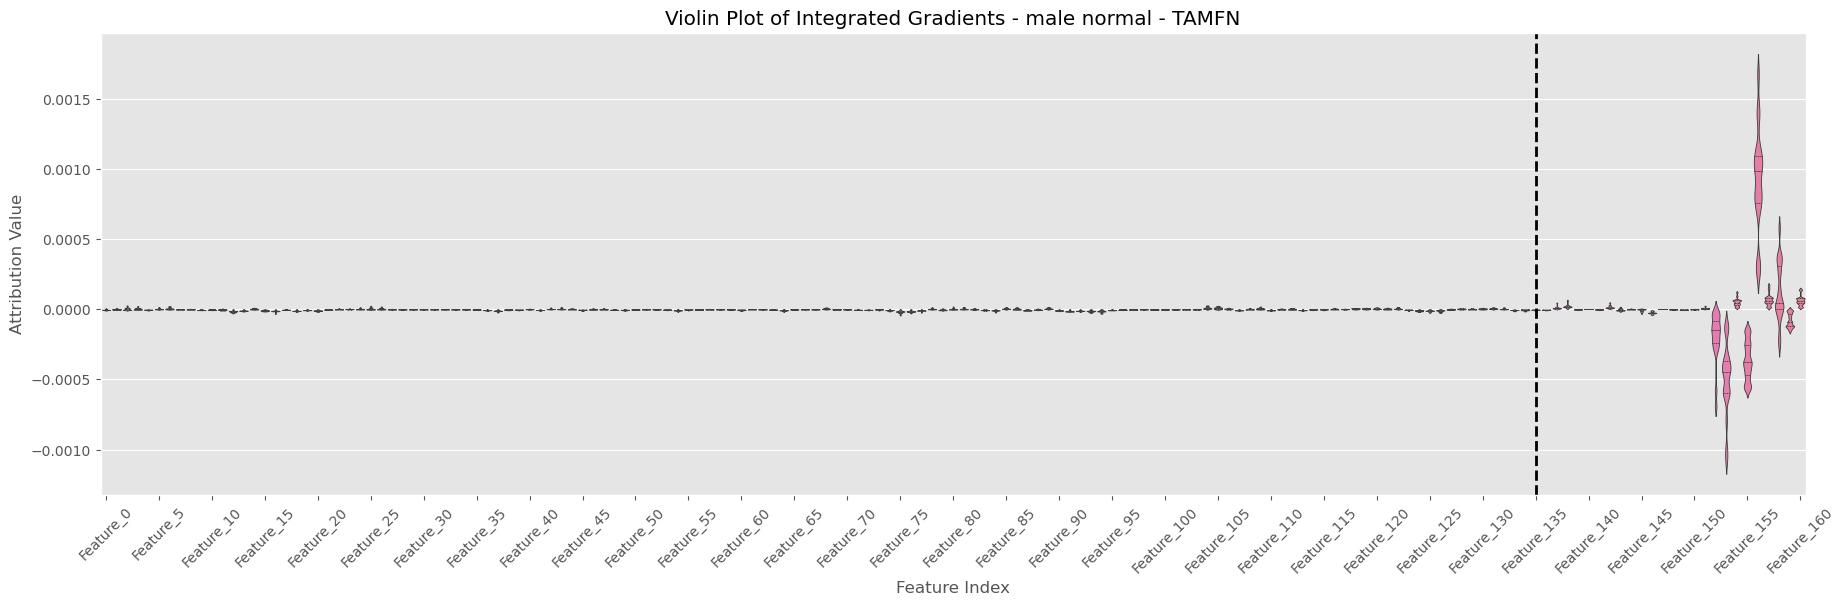

In [13]:
data = ig_attribute(ig, Xmn, n_steps=20)
plot_heatmap(data, "male normal - TAMFN")
plot_violin(data, "male normal - TAMFN")

### d. Femal Normal

mean(delta)=-0.007018692980555941, lower abs is better!
torch.Size([26, 161])
tensor(0.0011, dtype=torch.float64)


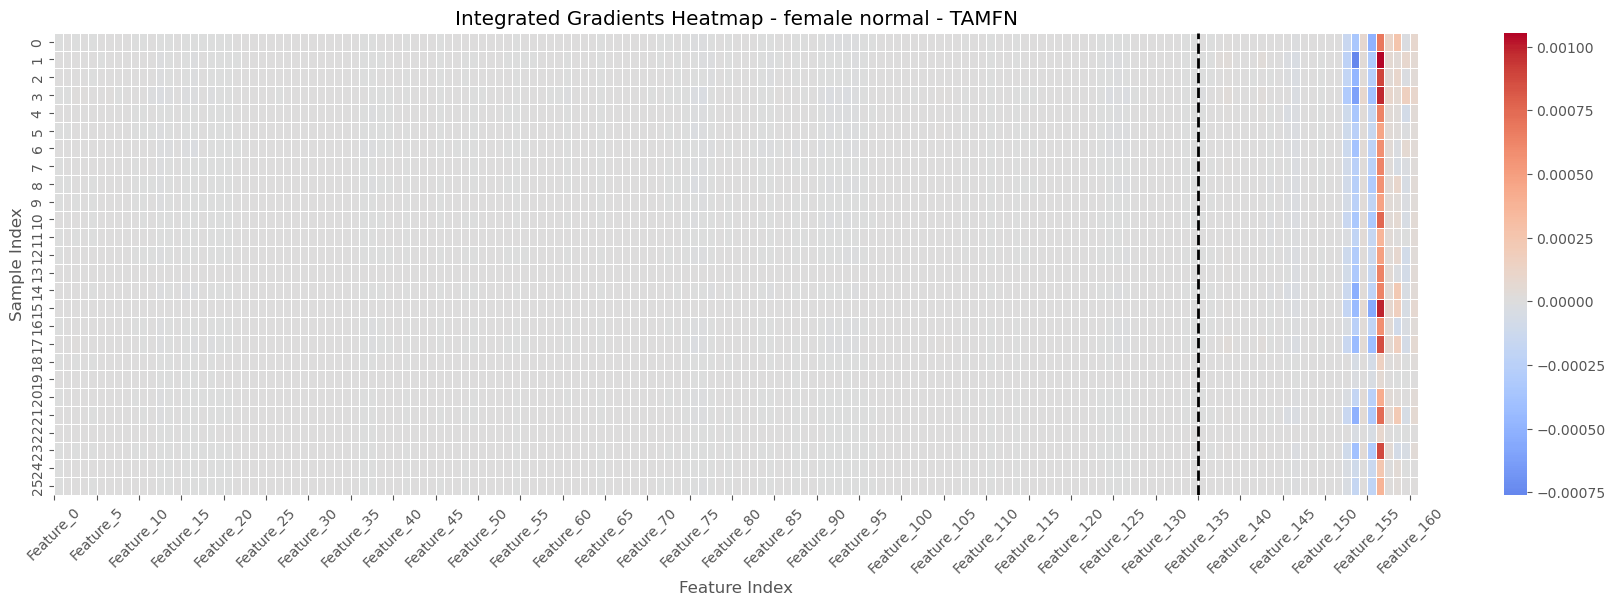

/var/folders/pf/8d2xqvf51pn0q9w51blgjmqc0000gn/T/ipykernel_47055/3149416675.py:27: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=data, inner="quartile", bw=0.2)


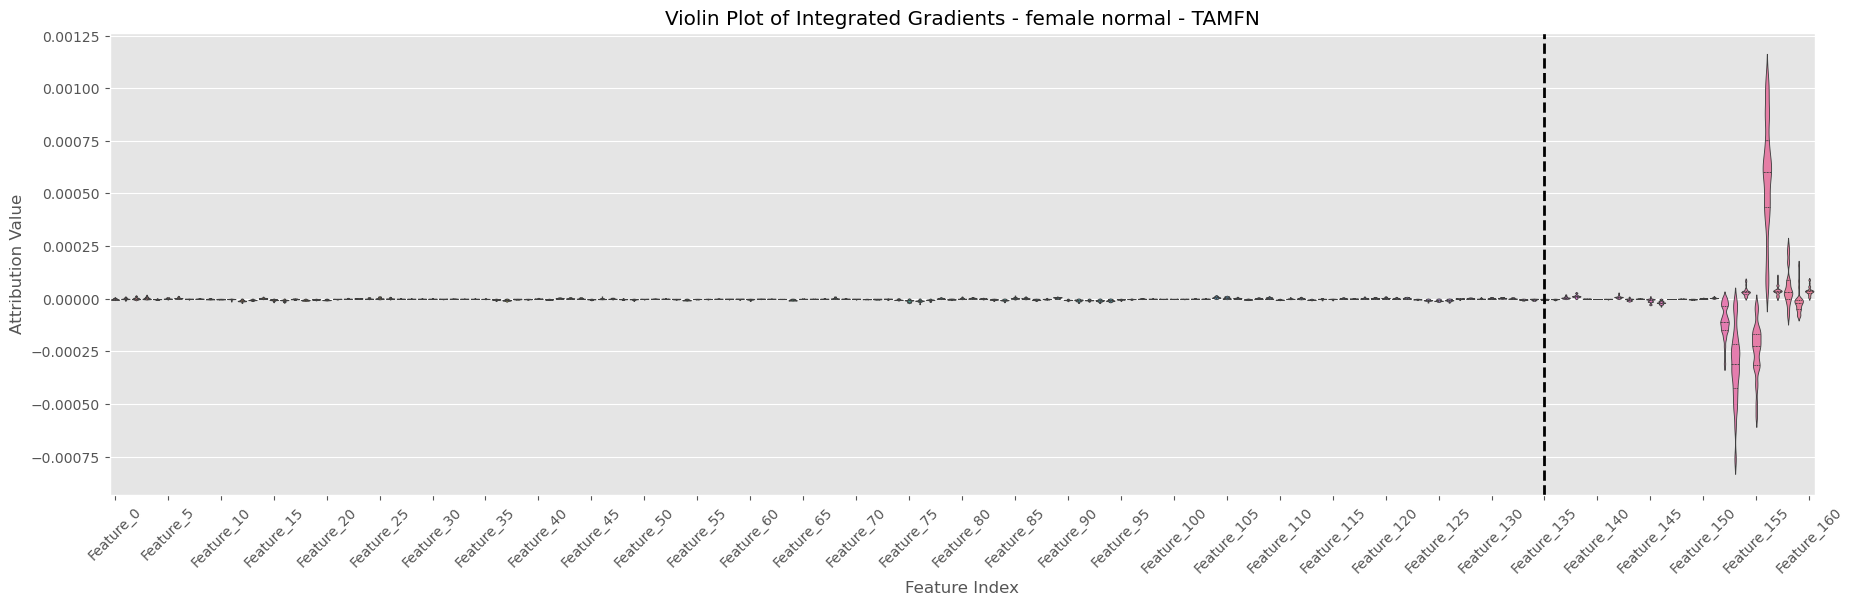

In [14]:
data = ig_attribute(ig, Xfn, n_steps=20)
plot_heatmap(data, "female normal - TAMFN")
plot_violin(data, "female normal - TAMFN")